In [1]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

def build_and_compile_model(norm):
  model = keras.Sequential([
      layers.InputLayer(input_shape=(4,)),
      norm,
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(2)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.0001))
  return model

In [3]:
dataset = pd.read_csv('ebw_data.csv')

In [4]:
dataset.astype(float)

,IW,IF,VW,FP,Depth,Width
0,47.0,139.0,4.5,80.0,1.60,2.54
1,47.0,139.0,4.5,80.0,1.62,2.50
2,47.0,139.0,4.5,80.0,1.68,2.60
3,47.0,139.0,4.5,80.0,1.58,2.52
4,45.0,140.0,4.5,80.0,1.76,2.48
...,...,...,...,...,...,...
67,44.0,146.0,9.0,60.0,1.20,1.72
68,45.0,146.0,9.0,60.0,1.36,1.76
69,45.0,146.0,9.0,60.0,1.28,1.76
70,45.0,146.0,9.0,60.0,1.28,1.76


In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features[['Depth', 'Width']]
train_features.drop(['Depth', 'Width'], axis=1, inplace=True)

test_labels = test_features[['Depth', 'Width']]
test_features.drop(['Depth', 'Width'], axis=1, inplace=True)

In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[ 45.706898 141.12068    8.491379  79.05173 ]]


In [8]:
first = np.array(train_features[:1])
with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 47. 134.  10. 110.]]

Normalized: [[ 0.76 -1.36  0.72  1.43]]


In [9]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               640       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 33,931
Trainable params: 33,922
Non-trainable params: 9
____________________________________________________

In [10]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-7,
        patience=5,
        verbose=1,
    )
]

In [11]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000, 
    callbacks=callbacks
)

Epoch 268: early stopping
CPU times: total: 8.98 s
Wall time: 7.94 s


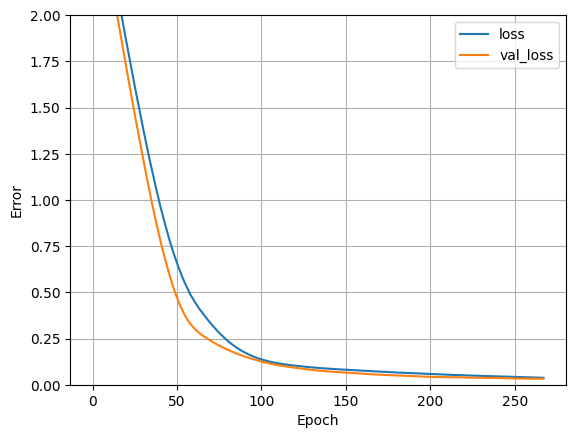

In [12]:
plot_loss(history)

In [13]:
score = dnn_model.evaluate(test_features, test_labels)
print('loss:', score)

1/1 [==============================] - 0s 19ms/step - loss: 0.0729
loss: 0.07288115471601486


In [14]:
test_predictions = dnn_model.predict(test_features)

1/1 [==============================] - 0s 73ms/step


In [15]:
mse = mean_squared_error(test_labels, test_predictions)
print(mse)

0.07288114886238577


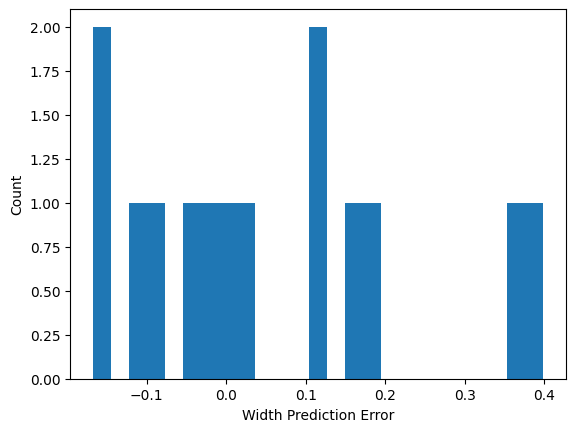

In [36]:
error = test_predictions[:, 1] - test_labels['Width']
plt.hist(error, bins=25)
plt.xlabel('Width Prediction Error')
_ = plt.ylabel('Count')

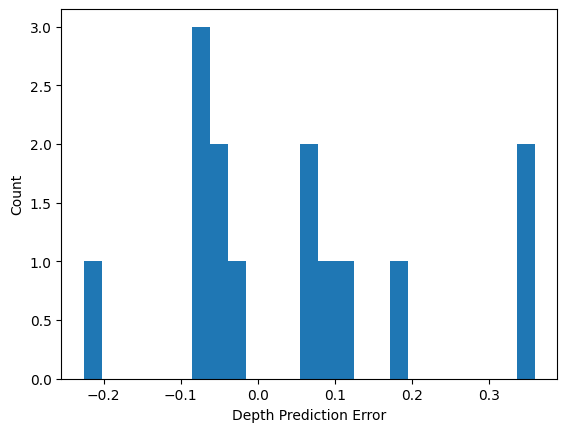

In [37]:
error = test_predictions[:, 0] - test_labels['Depth']
plt.hist(error, bins=25)
plt.xlabel('Depth Prediction Error')
_ = plt.ylabel('Count')

In [ ]:
IW = float(input('IW - '))

In [ ]:
IF = float(input('IF - '))

In [ ]:
VW = float(input('VW - '))

In [ ]:
FP = float(input('FP - '))

In [ ]:
X1 = pd.DataFrame(data = np.array([IW, IF, VW, FP], ndmin=2), columns = ['IW', 'IF', 'VW', 'FP'])

In [ ]:
y1 = dnn_model.predict(X1)

In [ ]:
print('Deep Neural Network prediction')
print(f'Depth = {round(y1[0, 0], 2)}')
print(f'Width = {round(y1[0, 1], 2)}')

In [38]:
# Save the model
dnn_model.save('ebw-dnn-model.h5')